# Count the colony in a petry dish

In [8]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os

def visualize_predictions(model, image_path, label_path, iou_threshold=0.5):
    """
    Visualize YOLO predictions vs ground truth.

    Args:
        model (YOLO): Loaded YOLO model.
        image_path (str): Path to the image file.
        label_path (str): Path to the YOLO-format label file.
        iou_threshold (float): IoU threshold to filter non-overlapping predictions.
    """

    # --- Load image ---
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Could not load image: {image_path}")
        return [], [], []

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    # --- Load GT boxes safely ---
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) < 5:  # skip invalid lines
                    continue
                try:
                    cls, x_c, y_c, w, h = map(float, parts[:5])
                except ValueError:
                    continue
                x1 = (x_c - w/2) * width
                y1 = (y_c - h/2) * height
                x2 = (x_c + w/2) * width
                y2 = (y_c + h/2) * height
                gt_boxes.append((x1, y1, x2, y2, int(cls)))
    else:
        print(f"⚠️ No label file found for {image_path}, skipping GT.")

    # --- Get predictions ---
    results = model(image_path)[0]
    pred_boxes = []
    for box, cls, score in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
        x1, y1, x2, y2 = box.cpu().numpy()
        pred_boxes.append((x1, y1, x2, y2, int(cls.cpu().numpy()), float(score.cpu().numpy())))

    # --- Function to compute IoU ---
    def compute_iou(box1, box2):
        xA = max(box1[0], box2[0])
        yA = max(box1[1], box2[1])
        xB = min(box1[2], box2[2])
        yB = min(box1[3], box2[3])
        inter_area = max(0, xB - xA) * max(0, yB - yA)
        box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
        box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
        iou = inter_area / float(box1_area + box2_area - inter_area + 1e-6)
        return iou

    # --- Filter predictions not overlapping GT ---
    non_overlap_preds = []
    for pred in pred_boxes:
        overlaps = [compute_iou(pred[:4], gt[:4]) for gt in gt_boxes]
        if not overlaps or all(iou < iou_threshold for iou in overlaps):
            non_overlap_preds.append(pred)

    # --- Print number of boxes ---
    print(f"Total GT boxes: {len(gt_boxes)}")
    print(f"Total predicted boxes: {len(pred_boxes)}")
    print(f"Predictions with IoU < {iou_threshold}: {len(non_overlap_preds)}")

    # --- Plot subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # 1️⃣ GT only
    axes[0].imshow(img)
    for x1, y1, x2, y2, cls in gt_boxes:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
        axes[0].add_patch(rect)
    axes[0].set_title(f"Ground Truth ({len(gt_boxes)} boxes)")
    axes[0].axis("off")

    # 2️⃣ Predictions only
    axes[1].imshow(img)
    for x1, y1, x2, y2, cls, score in pred_boxes:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)
        # Show class and confidence
        #axes[1].text(x1, y1-5, f"{cls}:{score:.2f}", color='red', fontsize=8)
    axes[1].set_title(f"Predictions ({len(pred_boxes)} boxes)")
    axes[1].axis("off")

    plt.show()

    return gt_boxes, pred_boxes, non_overlap_preds


image 1/1 c:\Users\bonte\Desktop\dev\YOLO\colony\final\images\2.jpg: 640x640 255 targets, 23.8ms
Speed: 3.7ms preprocess, 23.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Total GT boxes: 251
Total predicted boxes: 255
Predictions with IoU < 0.3: 3


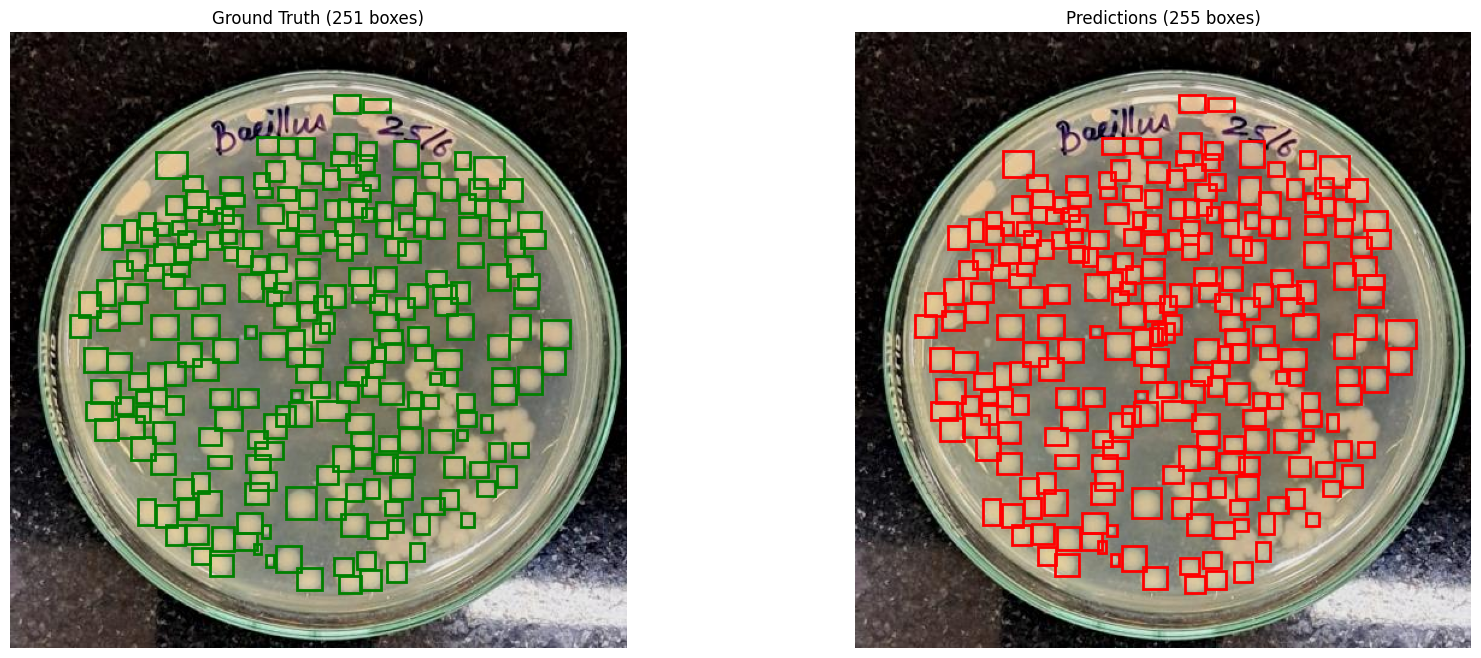


image 1/1 c:\Users\bonte\Desktop\dev\YOLO\colony\final\images\3.jpg: 640x640 54 targets, 26.1ms
Speed: 3.2ms preprocess, 26.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)
Total GT boxes: 55
Total predicted boxes: 54
Predictions with IoU < 0.3: 0


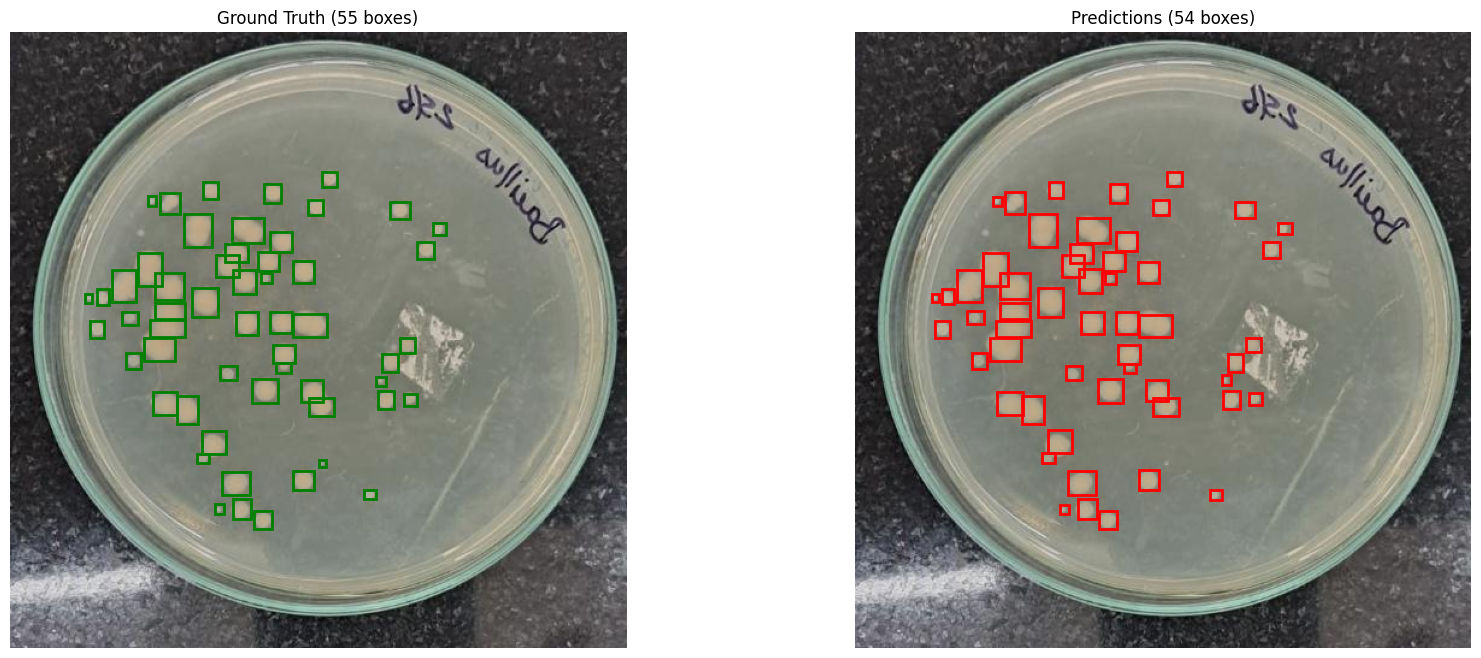


image 1/1 c:\Users\bonte\Desktop\dev\YOLO\colony\final\images\4.jpg: 640x640 300 targets, 25.7ms
Speed: 3.0ms preprocess, 25.7ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)
Total GT boxes: 817
Total predicted boxes: 300
Predictions with IoU < 0.3: 1


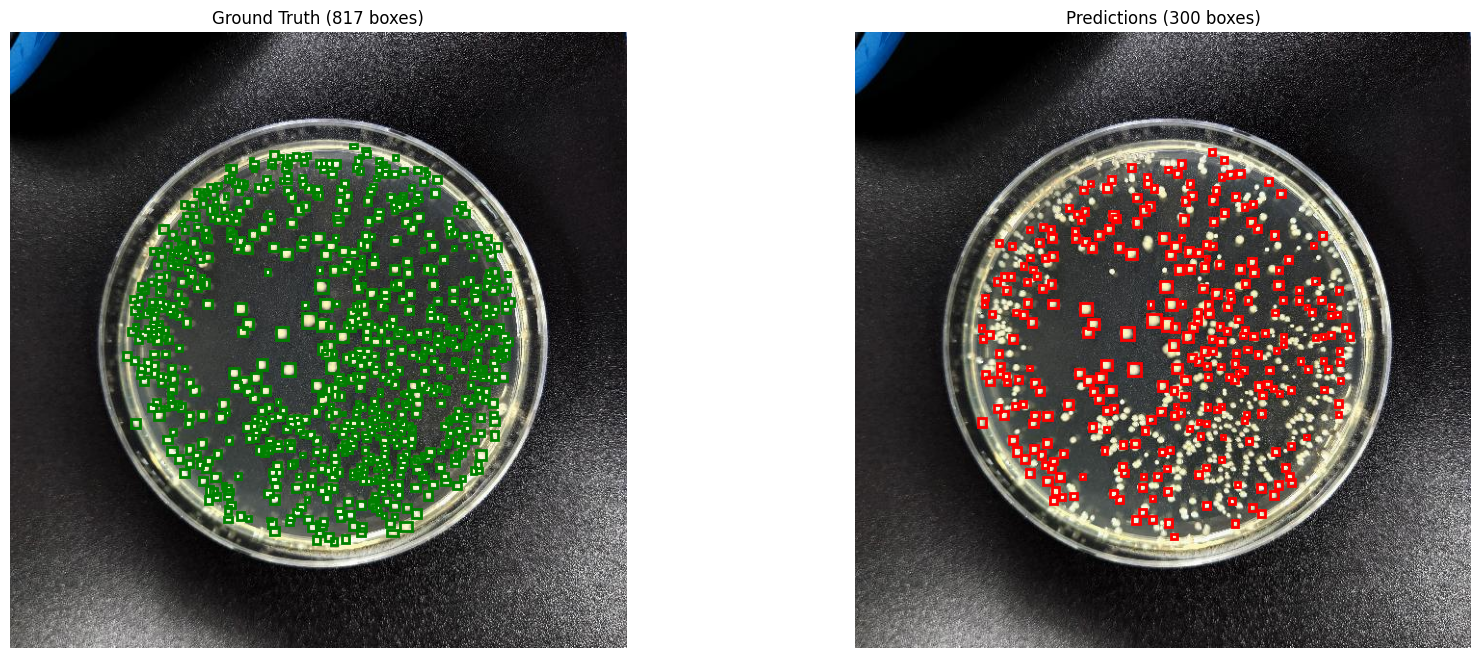

In [10]:
img_list=[2,3,4]
for i in img_list:
    model = YOLO("best.pt")
    image_path = "images/"+str(i)+".jpg"
    label_path = "labels/"+str(i)+".txt"

    gt_boxes, pred_boxes, non_overlap_preds = visualize_predictions(model, image_path, label_path, iou_threshold=0.3)
